# Skrinning Stuff

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

currentDir = os.getcwd()
sys.path.append(os.path.join(currentDir, '../code/'))
import geomUtils as geom
import IceSheet

In [2]:
geom.charLength('hex', [2.])

1.7320508075688774

In [3]:
diamsCrystal = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.])  # m
gapMelt = 1.e-4  # m

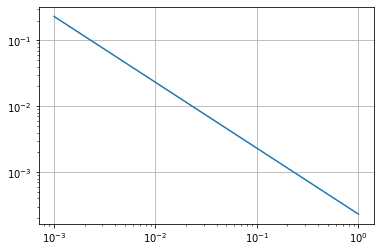

In [4]:
porosities = [(geom.periphery('hex', [x])*gapMelt/2)/(geom.area('hex', [x])) for x in diamsCrystal]
plt.loglog(diamsCrystal, porosities)
plt.grid()

In [5]:
mySheet = IceSheet.IceSheet(type='lake', thickness=100.0, crystalSize=100.0)

Ice type: lake
I0 = 50.000, alpha = 10.000


In [6]:
A, B, b, U = mySheet.setupModel(IC=[-2., 0.], windSpeed=5., aEnv=[0.15, 0.75, 0.1], TEnv=[-2.0, -20.0, -270.], Nx=51, Ny=101)
A

thermal diffusivity a = 1.14e-06 m2/s
spatial stepsize dz = 2.00 mm
temporal stepsize dt = 87.70 s
timescale tScale = 8769.8 s
sigma = 12.5
qRad = -86 W/m2, alphaRad = -86 W/(m2 K), Bi = 6.38e-01
i0 = 1.131
non-dim irradiance source term at top, bottom = 1.131, 0.408


array([[ 26.31900317, -25.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-12.5       ,  26.        , -12.5       , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , -12.5       ,  26.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  26.        ,
        -12.5       ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., -12.5       ,
         26.        , -12.5       ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        -12.5       ,  26.        ]])

In [7]:
USoln = []
USoln.append(U)

for idx in range(1, 100):
    U_new = np.linalg.solve(A, B.dot(U) + b)
    U = U_new
    USoln.append(U)
    
USoln = np.array(USoln)

[ 0  1  4  9 29 99]


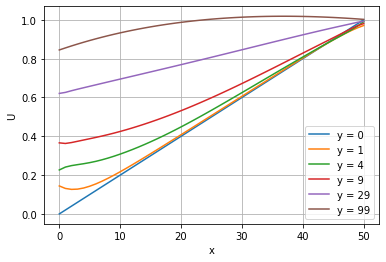

In [8]:
plt.xlabel('x'); plt.ylabel('U')
# times = np.array([0., 0.1, 0.2, 0.5, 1., 2., 5.])  # h
# timeIndeces = (times*3600/tScale*Ny + 0.5).astype(int)
timeIndeces = np.array([1, 2, 5, 10, 30, 100]) - 1
print(timeIndeces)
for timeIndex in timeIndeces:
    plt.plot(range(len(USoln[timeIndex])), USoln[timeIndex], label='y = '+'{}'.format(timeIndex))
# plt.xlim(0, 0.1)
plt.legend()
plt.grid()
plt.show()